# Eigen-character

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
sys.path.append("../30_Code/")

In [3]:
import Fusiform
import matplotlib.pyplot as plt
import numpy as np

## is this even plausible??
say, I got 300 characters document, each drawn on a 64x64 canvas, this will be a _dense_ matrix with dimensions of $ 4096 \times 300$ which would take up 9.3M computer memory (4096*300*8bytes without overhead). But this matrix would surely be rank-deficit(since there are bound to be duplicated characters), this does not seem to be efficient representation. The matrix should be weighted though, then the matrix columns can be each character type, or window type. 

Putting aside efficiency, I guess the matrix could be scaled up to 1G in size in desktop without problem. A 1G matrix could incorporate 32,768 columns (a column could be data of a character), which are fairly enough for common characters.

Then let's try a simple matrix, with 1000 frequently characters, without weighting, drawn on a 64*64 convas, and do a SVD decomposition. Find the singular vector on the character space

## 1. Build the matrix

### i. load first 1000 frequently characters

In [4]:
import pickle
with open("../05_Resource/as_chFreq.pickle", "rb") as fin:
    as_chfreq = pickle.load(fin)
    chars = sorted(as_chfreq.keys(), key=as_chfreq.get, reverse=True)
    freq_chars = chars[:1000]
print(freq_chars[:50] + ["..."] + freq_chars[-50:])
# kind of curious about the stroke distribution of these characters

['的', '一', '是', '不', '有', '在', '人', '我', '了', '大', '這', '以', '為', '個', '中', '他', '會', '來', '國', '上', '時', '要', '生', '到', '學', '們', '就', '可', '年', '也', '之', '出', '對', '而', '能', '說', '地', '成', '所', '多', '於', '得', '家', '十', '自', '後', '都', '子', '用', '與', '...', '績', '危', '露', '惡', '溝', '散', '臉', '航', '跳', '幸', '畢', '衣', '廿', '紛', '享', '怪', '季', '楚', '概', '伊', '迷', '索', '驚', '招', '遇', '迎', '武', '胡', '詩', '廳', '盛', '賞', '培', '私', '掌', '融', '射', '佛', '複', '努', '納', '途', '拍', '席', '肯', '田', '鐵', '喝', '拜', '籍']


### ii. check stroke distribution  
Strokes could be the most informative (and easily availabel) properties when analyzing visual aspect of characters

missing strokes data: 0
Strokes stat: 
M = 10.387, Med = 10.0, 
SD = 4.34, Min = 1, Max = 25
Characters with stroke >18: (46) ['體', '關', '灣', '覺', '觀', '變', '讓', '議', '類', '難', '權', '聽', '驗', '識', '藝', '邊', '歡', '顯', '響', '續', '黨', '離', '讀', '護', '證', '願', '屬', '警', '嚴', '顧', '蘇', '蘭', '競', '繼', '羅', '麗', '藥', '懷', '壞', '寶', '靈', '露', '驚', '廳', '鐵', '籍']


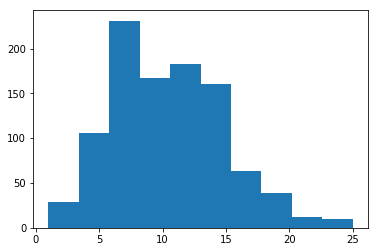

In [5]:
import json
with open("../05_Resource/stk_data.json", "r", encoding="UTF-8") as fin:
    stk_data = json.load(fin)
    freq_chars_stk = [stk_data.get(ch) for ch in freq_chars if ch in stk_data]
print(f"missing strokes data: {len(freq_chars) - len(freq_chars_stk)}")
plt.hist(freq_chars_stk)
print(f"Strokes stat: \nM = {np.mean(freq_chars_stk)}, "
      f"Med = {np.median(freq_chars_stk)}, \nSD = {np.std(freq_chars_stk):.2f}, "
      f"Min = {min(freq_chars_stk)}, Max = {max(freq_chars_stk)}")
cplx_chars = [ch for ch in freq_chars if stk_data.get(ch,-1) > 18]
print(f"Characters with stroke >18: ({len(cplx_chars)})", cplx_chars)

## 2. Try digesting first 10 characters into a matrix

### i. digest first 10 characters

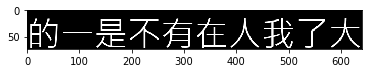

In [6]:
freq_ch10_str = "".join(freq_chars[:10])
txt_w, txt_h = Fusiform.measure_text(freq_ch10_str)
im = Fusiform.text2bitmap(freq_ch10_str, (txt_w, txt_h+1))
plt.imshow(im)

In [7]:
mat_digestor = Fusiform.MatrixDigestor(
                    Fusiform.spotlight.spotlight_rectangle, 
                    Fusiform.steps.step_char_wise)

In [8]:
M, _ = mat_digestor.digest(im, xoffset=0, nchar=1, step_overlap=False)

Note: note how reshaping transform the dimension. In MatrixDigestor, I simpy use reshape default order (order='C', column major, with the last axis index changing fastest, and the first axis index changing slowest) to flatten the matrix into vector. However, when reshape back, I need to use 'Fortran' order (order='F', row major, with the first index changing fastest, and the last index changing slowest). 
c.f. https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

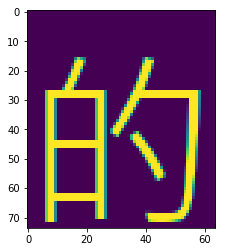

In [9]:
im_height = im.size[1]
plt.imshow(M[:,0].reshape([-1,im_height], order='F').transpose())

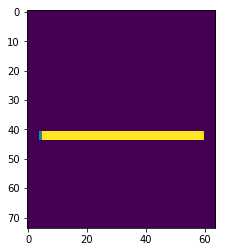

In [66]:
def recon_char(vec):
    return vec.reshape([-1,im_height], order='F').transpose()
plt.imshow(recon_char(M[:,1]))

### ii. decomposing M

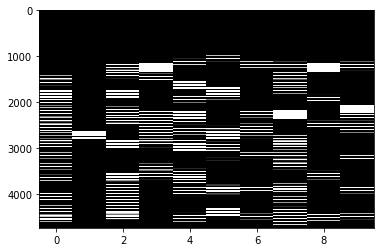

In [10]:
plt.imshow(M, interpolation='nearest', aspect='auto', cmap='gray')

Use numpy SVD  
https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html  
If matrix get larger, considering this:  
https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html#sklearn.utils.extmath.randomized_svd
extmath.randomized_svd: compute the k-truncated randomized SVD. This algorithm finds the exact truncated singular values decomposition using randomization to speed up the computations. It is particularly fast on large matrices on which you wish to extract only a small number of components.

In [11]:
U, S, V = np.linalg.svd(M)

In [12]:
print(f"dimensions: U({U.shape}), S({S.shape}), V({V.shape})")

dimensions: U((4736, 4736)), S((10,)), V((10, 10))


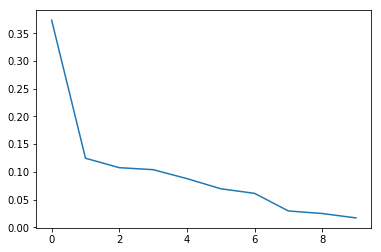

In [61]:
# Frobenius norm: root sum of square of singular values (see appendix)
fnorm2 = np.sum(S**2)
S_prop = S**2/fnorm2
plt.plot(S_prop)

### iii. reconstruct with truncated singular vectors

#### a. recon with K = 2

In [37]:
k = 2
Ut, St, Vt = U[:,:k], S[:k], V[:k, :]

In [38]:
Mt = np.dot(np.dot(Ut, np.diag(St)), Vt)

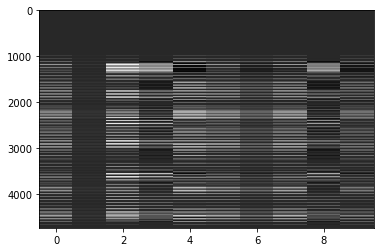

In [39]:
plt.imshow(Mt, interpolation='nearest', aspect='auto', cmap='gray')

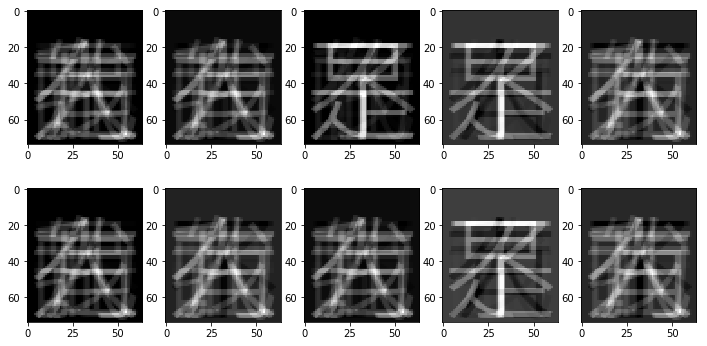

In [67]:
from itertools import chain
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(12, 6)
for i, ax in enumerate(chain.from_iterable(axes)):
    ax.imshow(recon_char(Mt[:,i]), cmap='gray')

#### Recon with K=7

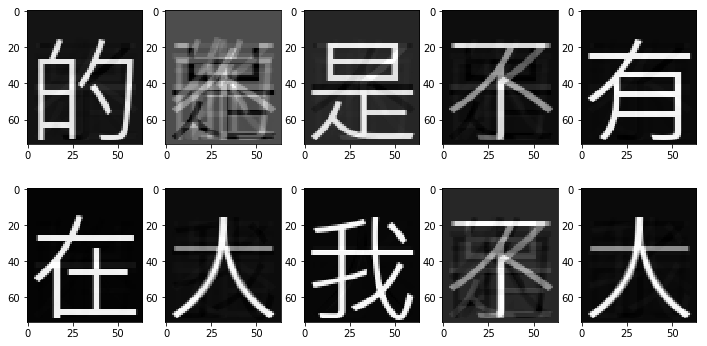

In [75]:
k = 7
Ut, St, Vt = U[:,:k], S[:k], V[:k, :]
Mt = np.dot(np.dot(Ut, np.diag(St)), Vt)
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(12, 6)
for i, ax in enumerate(chain.from_iterable(axes)):
    ax.imshow(recon_char(Mt[:,i]), cmap='gray')

#### c. Recon with K = 10 (should be fully reconstructed)

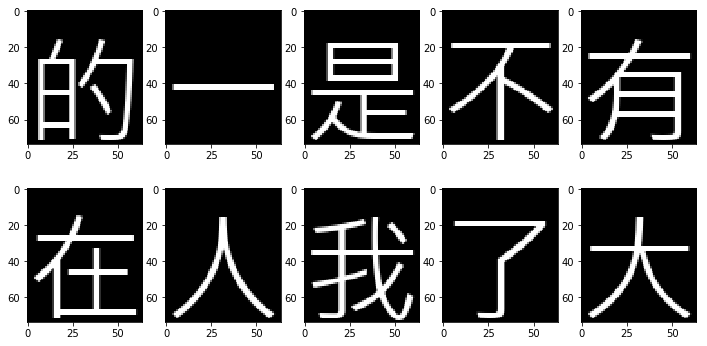

In [73]:
k = 10
Ut, St, Vt = U[:,:k], S[:k], V[:k, :]
Mt = np.dot(np.dot(Ut, np.diag(St)), Vt)
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(12, 6)
for i, ax in enumerate(chain.from_iterable(axes)):
    ax.imshow(recon_char(Mt[:,i]), cmap='gray')

### iv. What's the singular vectors??

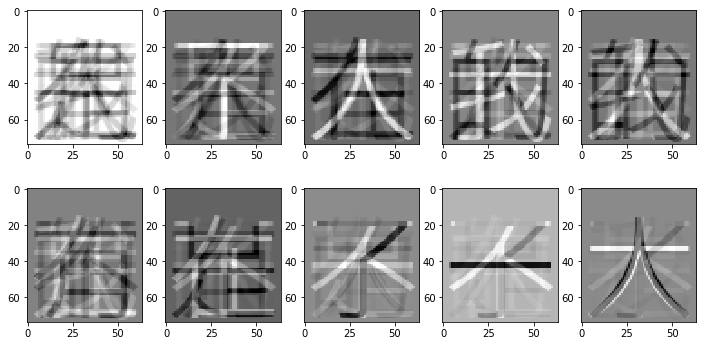

In [80]:
fig, axes = plt.subplots(2, 5, squeeze=False)
fig.set_size_inches(12, 6)
for v, ax in enumerate(chain.from_iterable(axes)):
    ax.imshow(recon_char(U[:,v]), cmap='gray')

# Appendix

From [Wikipedia][link]:
When p = q = 2 for the $L_{p,q}$ norm, it is called the '''Frobenius norm''' or the '''Hilbert–Schmidt norm''', though the latter term is used more frequently in the context of operators on (possibly infinite-dimensional) [[Hilbert space]]. This norm can be defined in various ways:

$$
\|A\|_{\rm F} = \sqrt{\sum_{i=1}^m \sum_{j=1}^n |a_{ij}|^2} = \sqrt{\operatorname{trace}\left(A^* A\right)} = \sqrt{\sum_{i=1}^{\min\{m, n\}} \sigma_i^2(A)}
$$

[link]: https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm

In [53]:
# root sum of square of each matrix elemennts
np.sqrt(np.sum(M**2))

19667.999110229794

In [54]:
# square of trace
np.sqrt(np.trace(np.dot(np.transpose(M), M)))

19667.999110229794

In [55]:
# root sum of square of singular values
np.sqrt(np.sum(S**2))

19667.999110229797